In [192]:
import json
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import Dataset, DataLoader
from pathlib import Path

In [254]:
# Importing the dataset.
# The LIDAR server produces samples at 30Hz with object positions normalized in their
# space, i.e. x and y values are in the 0-1 range.
datadir = Path("../testdata")
names = [
    "dump-1731964073793.jsonl",
    "dump-1731965089198.jsonl",
    "dump-1731966752296.jsonl",
    "dump-1732220377000.jsonl",
    "dump-1732378712139.jsonl"
]

data = []
for name in names:
    path = datadir.joinpath(datadir, name)
    f = open(path, 'r')
    last_is_zero = False
    points = []
    for line in f.readlines():
        d = json.loads(line)
        if d['type'] != 'object':
            continue
        payload = d['payload']
        # At the beginning and end of the session there is nobody on stage and
        # there are many 0,0 points.
        is_zero = payload['x'] == 0 and payload['y'] == 0
        if is_zero:
            continue
            
        points.append({
            'x': payload['x'],
            'y': payload['y'],
        })
    data.append(points)

In [255]:
class SequenceToSequenceDataset(Dataset):
    # Instead of predicting the next point, we make the network predict
    # the next trajectory. This way, it will be forced to imitate the
    # behaviour of the training setup.
    def __init__(self, data, sequence_length=90):
        self.sequence_length = sequence_length

        for points in data:     
            # Convert data to numpy array
            xy_points = np.array([[d['x'], d['y']] for d in points])
        
            # Create sequences
            self.sequences = []
            self.targets = []
        
            for i in range(len(xy_points) - (sequence_length * 2)):
                start = i
                mid = i + sequence_length
                end = mid + sequence_length
            
                self.sequences.append(xy_points[start:mid])
                self.targets.append(xy_points[mid:end])
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        return torch.as_tensor([self.sequences[idx], self.targets[idx]], dtype=torch.float32)

In [256]:
# Checking that the dataset works.
dataset = SequenceToSequenceDataset(data)
next(iter(dataset)).shape

torch.Size([2, 90, 2])

In [257]:
class TrajectoryPredictor(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=128, lstm_layers=3, dense_layers=[64, 32, 16], output_dim=2):
        super(TrajectoryPredictor, self).__init__()
        
        # LSTM layers for temporal processing
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=lstm_layers,
            batch_first=True
        )
        
        # Fully connected layers for further feature processing
        dense_layers_list = []
        input_size = hidden_dim
        for layer_size in dense_layers:
            dense_layers_list.append(nn.Linear(input_size, layer_size))
            dense_layers_list.append(nn.ReLU())
            input_size = layer_size
        self.fc = nn.Sequential(*dense_layers_list)
        
        # Output layer with Sigmoid activation
        self.output_layer = nn.Linear(input_size, output_dim)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        # x: (batch_size, input_sequence_length, input_dim)
        lstm_out, _ = self.lstm(x)  # lstm_out: (batch_size, input_sequence_length, hidden_dim)
        dense_out = self.fc(lstm_out)  # Pass each timestep's hidden state through dense layers
        output = self.sigmoid(self.output_layer(dense_out))  # Output: (batch_size, input_sequence_length, output_dim)
        return output

In [252]:
# Checking that the model works
model = TrajectoryPredictor()
with torch.no_grad():
    dummy_input = torch.rand(1, 5, 2)
    # Forward pass
    output = model(dummy_input)
    print(output) 

tensor([[[0.5558, 0.5719],
         [0.5559, 0.5719],
         [0.5560, 0.5719],
         [0.5560, 0.5719],
         [0.5561, 0.5719]]])


In [267]:
# Training
from accelerate import Accelerator
import torch
import torch.nn as nn
import torch.optim as optim
from datetime import datetime
from tqdm import tqdm
from torch.utils.data import DataLoader, random_split
import wandb



# Initialize Accelerator
accelerator = Accelerator()

current_date = datetime.now().strftime("%Y-%m-%d")
num_epochs = 200
patience = 20  # Early stopping patience
best_val_loss = float("inf")
epochs_without_improvement = 0
best_path = ""

# Hyperparams
lr = 1e-3
sequence_length=90
hidden_dim=128
lstm_layers=3
dense_layers=[64, 32, 16]
batch_size = 32

# Initialize the dataset
dataset = SequenceToSequenceDataset(data, sequence_length=sequence_length)

# Define split ratios
train_ratio = 0.8
val_ratio = 0.2

# Compute split sizes
dataset_size = len(dataset)
train_size = int(train_ratio * dataset_size)
val_size = dataset_size - train_size

# Split dataset
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoaders

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Define model, optimizer, and loss function
model = TrajectoryPredictor(hidden_dim=hidden_dim, lstm_layers=lstm_layers, dense_layers=dense_layers)

optimizer = optim.Adam(model.parameters(), lr=lr)
loss_fn = nn.MSELoss()  # Mean Squared Error for position regression

# Prepare everything with Accelerate
model, optimizer, train_loader, val_loader = accelerator.prepare(
    model, optimizer, train_loader, val_loader
)

wandb.init(
    # set the wandb project where this run will be logged
    project="afterlife",

    # track hyperparameters and run metadata
    config={
    "learning_rate": lr,
    "architecture": "LSTM",
    "dataset": "MAX",
    "epochs": num_epochs,
    "sequence_length":sequence_length,
    "hidden_dim": hidden_dim,
    "lstm_layers": lstm_layers,
    "dense_layers": dense_layers,
    "batch_size": batch_size
    }
)

for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs} - Training"):
        inputs, targets = batch[:, 0], batch[:, 1]

        optimizer.zero_grad()
        outputs = model(inputs)  # Forward pass
        loss = loss_fn(outputs, targets)  # Compute loss
        accelerator.backward(loss)  # Backpropagation using Accelerate
        optimizer.step()
        
        train_loss += loss.item()

    train_loss /= len(train_loader)

    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Validating"):
            inputs, targets = batch[:, 0], batch[:, 1]
            outputs = model(inputs)
            loss = loss_fn(outputs, targets)
            val_loss += loss.item()

    val_loss /= len(val_loader)

    # Log results
    print(f"Epoch {epoch + 1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
    wandb.log({"train_loss": train_loss, "val_loss": val_loss})

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0
        # Save the best model
        path = f"../snapshots/snapshot-{current_date}_best_model_epoch_{epoch + 1}"
        accelerator.save_state(path)
        best_path = f"{path}/model.safetensors"
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= patience:
            print("Early stopping triggered!")
            break

# Final cleanup
print(f"Training complete. Model is stored at {best_path}. Best Validation Loss: {best_val_loss}")
wandb.finish()

train_loss,▁
val_loss,▁
train_loss,0.05077
val_loss,0.05089


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 106/106 [00:00<00:00, 125.66it/s]


Epoch 1/200 - Train Loss: 0.0496, Val Loss: 0.0512


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 106/106 [00:00<00:00, 120.98it/s]


Epoch 2/200 - Train Loss: 0.0467, Val Loss: 0.0457


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 106/106 [00:00<00:00, 122.48it/s]


Epoch 3/200 - Train Loss: 0.0444, Val Loss: 0.0448


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 106/106 [00:00<00:00, 121.18it/s]


Epoch 4/200 - Train Loss: 0.0442, Val Loss: 0.0446


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 106/106 [00:00<00:00, 117.01it/s]


Epoch 5/200 - Train Loss: 0.0441, Val Loss: 0.0443


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 106/106 [00:00<00:00, 119.79it/s]


Epoch 6/200 - Train Loss: 0.0438, Val Loss: 0.0430


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 106/106 [00:00<00:00, 118.42it/s]


Epoch 7/200 - Train Loss: 0.0423, Val Loss: 0.0430


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 106/106 [00:00<00:00, 120.29it/s]


Epoch 8/200 - Train Loss: 0.0409, Val Loss: 0.0422


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 106/106 [00:00<00:00, 119.85it/s]


Epoch 9/200 - Train Loss: 0.0388, Val Loss: 0.0399


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 106/106 [00:00<00:00, 119.93it/s]


Epoch 10/200 - Train Loss: 0.0374, Val Loss: 0.0374


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 106/106 [00:00<00:00, 119.36it/s]


Epoch 11/200 - Train Loss: 0.0371, Val Loss: 0.0372


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 106/106 [00:00<00:00, 119.99it/s]


Epoch 12/200 - Train Loss: 0.0365, Val Loss: 0.0374


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 106/106 [00:00<00:00, 119.18it/s]


Epoch 13/200 - Train Loss: 0.0362, Val Loss: 0.0359


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 106/106 [00:00<00:00, 120.34it/s]


Epoch 14/200 - Train Loss: 0.0364, Val Loss: 0.0363


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 106/106 [00:00<00:00, 116.22it/s]


Epoch 15/200 - Train Loss: 0.0358, Val Loss: 0.0368


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 106/106 [00:00<00:00, 120.62it/s]


Epoch 16/200 - Train Loss: 0.0358, Val Loss: 0.0365


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 106/106 [00:00<00:00, 120.22it/s]


Epoch 17/200 - Train Loss: 0.0352, Val Loss: 0.0358


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 106/106 [00:00<00:00, 119.33it/s]


Epoch 18/200 - Train Loss: 0.0358, Val Loss: 0.0353


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 106/106 [00:00<00:00, 119.66it/s]


Epoch 19/200 - Train Loss: 0.0356, Val Loss: 0.0355


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 106/106 [00:00<00:00, 115.95it/s]


Epoch 20/200 - Train Loss: 0.0351, Val Loss: 0.0352


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 106/106 [00:00<00:00, 120.49it/s]


Epoch 21/200 - Train Loss: 0.0351, Val Loss: 0.0352


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 106/106 [00:00<00:00, 120.22it/s]


Epoch 22/200 - Train Loss: 0.0346, Val Loss: 0.0356


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 106/106 [00:00<00:00, 119.97it/s]


Epoch 23/200 - Train Loss: 0.0347, Val Loss: 0.0348


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 106/106 [00:00<00:00, 119.92it/s]


Epoch 24/200 - Train Loss: 0.0342, Val Loss: 0.0356


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 106/106 [00:00<00:00, 115.94it/s]


Epoch 25/200 - Train Loss: 0.0348, Val Loss: 0.0344


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 106/106 [00:00<00:00, 117.06it/s]


Epoch 26/200 - Train Loss: 0.0343, Val Loss: 0.0349


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 106/106 [00:00<00:00, 119.83it/s]


Epoch 27/200 - Train Loss: 0.0340, Val Loss: 0.0340


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 106/106 [00:00<00:00, 120.25it/s]


Epoch 28/200 - Train Loss: 0.0338, Val Loss: 0.0351


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 106/106 [00:00<00:00, 113.40it/s]


Epoch 29/200 - Train Loss: 0.0338, Val Loss: 0.0350


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 106/106 [00:00<00:00, 115.48it/s]


Epoch 30/200 - Train Loss: 0.0336, Val Loss: 0.0359


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 106/106 [00:00<00:00, 114.40it/s]


Epoch 31/200 - Train Loss: 0.0334, Val Loss: 0.0346


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 106/106 [00:00<00:00, 117.15it/s]


Epoch 32/200 - Train Loss: 0.0335, Val Loss: 0.0338


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 106/106 [00:00<00:00, 119.78it/s]


Epoch 33/200 - Train Loss: 0.0333, Val Loss: 0.0346


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 106/106 [00:00<00:00, 120.15it/s]


Epoch 34/200 - Train Loss: 0.0331, Val Loss: 0.0343


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 106/106 [00:00<00:00, 118.73it/s]


Epoch 35/200 - Train Loss: 0.0331, Val Loss: 0.0337


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 106/106 [00:00<00:00, 115.16it/s]


Epoch 36/200 - Train Loss: 0.0328, Val Loss: 0.0334


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 106/106 [00:00<00:00, 119.80it/s]


Epoch 37/200 - Train Loss: 0.0326, Val Loss: 0.0344


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 106/106 [00:00<00:00, 119.42it/s]


Epoch 38/200 - Train Loss: 0.0329, Val Loss: 0.0329


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 106/106 [00:00<00:00, 119.68it/s]


Epoch 39/200 - Train Loss: 0.0330, Val Loss: 0.0332


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 106/106 [00:00<00:00, 119.30it/s]


Epoch 40/200 - Train Loss: 0.0325, Val Loss: 0.0342


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 106/106 [00:00<00:00, 118.34it/s]


Epoch 41/200 - Train Loss: 0.0328, Val Loss: 0.0336


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 106/106 [00:00<00:00, 120.92it/s]


Epoch 42/200 - Train Loss: 0.0323, Val Loss: 0.0338


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 106/106 [00:00<00:00, 118.76it/s]


Epoch 43/200 - Train Loss: 0.0323, Val Loss: 0.0359


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 106/106 [00:00<00:00, 119.33it/s]


Epoch 44/200 - Train Loss: 0.0323, Val Loss: 0.0332


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 106/106 [00:00<00:00, 119.08it/s]


Epoch 45/200 - Train Loss: 0.0328, Val Loss: 0.0328


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 106/106 [00:00<00:00, 119.49it/s]


Epoch 46/200 - Train Loss: 0.0321, Val Loss: 0.0331


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 106/106 [00:00<00:00, 115.55it/s]


Epoch 47/200 - Train Loss: 0.0323, Val Loss: 0.0323


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 106/106 [00:00<00:00, 112.94it/s]


Epoch 48/200 - Train Loss: 0.0320, Val Loss: 0.0334


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 106/106 [00:00<00:00, 114.32it/s]


Epoch 49/200 - Train Loss: 0.0323, Val Loss: 0.0349


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 106/106 [00:00<00:00, 115.22it/s]


Epoch 50/200 - Train Loss: 0.0322, Val Loss: 0.0322


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 106/106 [00:00<00:00, 117.69it/s]


Epoch 51/200 - Train Loss: 0.0323, Val Loss: 0.0352


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 106/106 [00:00<00:00, 113.66it/s]


Epoch 52/200 - Train Loss: 0.0321, Val Loss: 0.0340


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 106/106 [00:00<00:00, 112.83it/s]


Epoch 53/200 - Train Loss: 0.0321, Val Loss: 0.0329


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 106/106 [00:00<00:00, 118.68it/s]


Epoch 54/200 - Train Loss: 0.0318, Val Loss: 0.0330


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 106/106 [00:00<00:00, 117.83it/s]


Epoch 55/200 - Train Loss: 0.0316, Val Loss: 0.0324


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 106/106 [00:00<00:00, 116.31it/s]


Epoch 56/200 - Train Loss: 0.0319, Val Loss: 0.0330


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 106/106 [00:00<00:00, 118.97it/s]


Epoch 57/200 - Train Loss: 0.0319, Val Loss: 0.0330


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 106/106 [00:00<00:00, 113.51it/s]


Epoch 58/200 - Train Loss: 0.0315, Val Loss: 0.0333


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 106/106 [00:00<00:00, 118.47it/s]


Epoch 59/200 - Train Loss: 0.0315, Val Loss: 0.0334


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 106/106 [00:00<00:00, 117.10it/s]


Epoch 60/200 - Train Loss: 0.0316, Val Loss: 0.0332
Early stopping triggered!
Training complete. Model is stored at ../snapshots/snapshot-2024-11-27_best_model_epoch_50/model.safetensors. Best Validation Loss: 0.03219879325479269


train_loss,█▆▆▅▅▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▆▅▅▄▃▂▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▂▁▁▁▁▁▂▂▁▁▁▁▁▁
train_loss,0.03162
val_loss,0.03317


In [261]:
import torch
from safetensors.torch import load_file

trained_model = TrajectoryPredictor()

# Load the parameters from the safetensors file
path = f"{best_path}/model.safetensors"
state_dict = load_file(path)

# Load the state_dict into your model
trained_model.load_state_dict(state_dict)

# Move model to the appropriate device (e.g., CPU or GPU)
device = torch.device("mps")
trained_model.to(device)

TrajectoryPredictor(
  (lstm): LSTM(2, 128, num_layers=3, batch_first=True)
  (fc): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=16, bias=True)
    (5): ReLU()
  )
  (output_layer): Linear(in_features=16, out_features=2, bias=True)
  (sigmoid): Sigmoid()
)

In [262]:
eval_loader = DataLoader(val_dataset, batch_size=1, shuffle=True)
item = next(iter(eval_loader)).squeeze(0)[0]
item.shape

torch.Size([100, 2])

In [263]:
with torch.no_grad():
    predicted = trained_model(item.to(device))
    
predicted = predicted.squeeze(0).detach().cpu()
print(predicted)
plot_data = torch.cat((have, predicted), dim=0)

tensor([[0.4842, 0.4415],
        [0.4671, 0.4734],
        [0.4769, 0.4197],
        [0.4894, 0.3944],
        [0.4932, 0.3923],
        [0.4837, 0.3554],
        [0.4715, 0.3364],
        [0.4693, 0.3291],
        [0.4692, 0.3214],
        [0.4709, 0.3078],
        [0.4760, 0.2825],
        [0.4783, 0.2744],
        [0.4794, 0.2716],
        [0.4789, 0.2892],
        [0.4797, 0.3513],
        [0.4856, 0.3848],
        [0.4891, 0.4099],
        [0.4900, 0.4163],
        [0.4921, 0.4245],
        [0.4926, 0.4207],
        [0.4929, 0.4185],
        [0.4923, 0.4232],
        [0.4914, 0.4332],
        [0.4903, 0.4445],
        [0.4887, 0.4492],
        [0.4878, 0.4548],
        [0.4866, 0.4626],
        [0.4852, 0.4720],
        [0.4837, 0.4792],
        [0.4823, 0.4849],
        [0.4809, 0.4913],
        [0.4798, 0.4968],
        [0.4791, 0.5006],
        [0.4786, 0.5051],
        [0.4782, 0.5095],
        [0.4778, 0.5137],
        [0.4774, 0.5177],
        [0.4771, 0.5217],
        [0.4

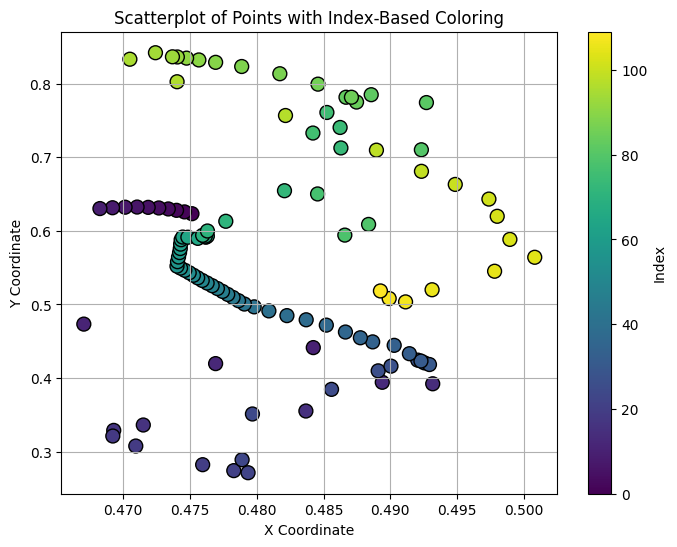

In [264]:
import matplotlib.pyplot as plt
import numpy as np

# Extract x, y coordinates
x, y = plot_data[:, 0], plot_data[:, 1]

# Generate colors based on indices
colors = np.arange(len(plot_data))

# Create scatter plot
plt.figure(figsize=(8, 6))
scatter = plt.scatter(x, y, c=colors, cmap='viridis', s=100, edgecolor='k')

# Add colorbar
plt.colorbar(scatter, label="Index")

# Add labels and grid
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.title("Scatterplot of Points with Index-Based Coloring")
plt.grid(True)
plt.show()